In [1]:
import IPython
iframe = '<div style="width: 100%;"><div style="position: relative; padding-bottom: 56.25%; padding-top: 0; height: 0;"><iframe frameborder="0" width="1200" height="675" style="position: absolute; top: 0; left: 0; width: 100%; height: 100%;" src="https://view.genial.ly/5f6532697ba1040d0cd5add7" type="text/html" allowscriptaccess="always" allowfullscreen="true" scrolling="yes" allownetworking="all"></iframe> </div> </div>'
IPython.display.HTML(iframe)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

<a id="top"></a>
## Tabla de contenidos

### <a href='#pregunta_negocio'> 0. Cual es la pregunta de negocio? </a>
### <a href='#carga_datos'> 1. Carga de los datos </a>
- #### <a href='#carga_dict'> Carga de los diccionarios </a>
- #### <a href='#replace_dict'> Diccionario de reemplazo </a>
- #### <a href='#column_selection'> Selección de columnas </a>
- #### <a href='#date_correction'> Correción de Fechas </a>
- #### <a href='#categoric_correction'> Correción de Categorias </a>
- #### <a href='#features'>Features y Target </a>
- #### <a href='#dummies'> Creación de Dummies </a>
### <a href='#clasificadores'> Clasificadores </a>
- #### <a href='#imports'> Imports Necesarios </a>
- #### <a href='#primer_solucion'> Primer Solución </a>
- #### <a href='#knn'> KNN </a>
- #### <a href='#regresion_logistica'> Regresión Logistica </a>
    - ##### <a href='#regresion_logistica_tune'> Tuneamos hiperparametros </a>
    - ##### <a href='#grafico_precission_recall'> Gráfico Precission-recall </a>
- #### <a href='#naive_gauss'> Naive Gauss </a>
- #### <a href='#comp_model'> Comparacion de Modelos </a>
    - ##### <a href='#conclusiones'> Conclusiones </a>
    - ##### <a href='#teoria'> Un poco de teoría </a>
    - ##### <a href='#reglog_analisis'> Análisis de la Regresión Logística </a>


<a id="pregunta_negocio"></a>
# Si me contagio de Covid en base a mi historial clínico y mi edad voy a:
## 1. Estar ambulatorio
## 2. Estar hospitalizado
- #### <a href='#top'> Tabla de Contenidos </a>

<a id="carga_datos"></a>
# Carga de datos 
- #### <a href='#top'> Tabla de Contenidos </a>

Obtuvimos los datos de la página oficial del ministerio de salud de México:
    https://www.gob.mx/salud/documentos/datos-abiertos-152127
    
Donde se puede ver el archivo con los datos actualizados día a día y además el diccionario de datos para entender que representa cada columna y su correspondiente códificación.

In [3]:
# Hacemos un read csv y tenemos la salvedad de cargar como str algunos campos porque es necesrio luego concatenarlos
# para poder traducirlos
mexico = pd.read_csv('200911COVID19MEXICO.csv', header=0, encoding= 'latin-1', dtype={'ENTIDAD_UM': 'str','ENTIDAD_NAC':'str', 'ENTIDAD_RES':'str', 'MUNICIPIO_RES':'str'})


In [4]:
# De todos los valores nos quedamos solo con los infectados por nuestra pregunta de negocio
mexicoInfectados = mexico[mexico['RESULTADO'] == 1].copy()

In [5]:
# Verificamos que se haya cargado correctamente
mexicoInfectados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658299 entries, 0 to 1003431
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   FECHA_ACTUALIZACION  658299 non-null  object
 1   ID_REGISTRO          658299 non-null  object
 2   ORIGEN               658299 non-null  int64 
 3   SECTOR               658299 non-null  int64 
 4   ENTIDAD_UM           658299 non-null  object
 5   SEXO                 658299 non-null  int64 
 6   ENTIDAD_NAC          658299 non-null  object
 7   ENTIDAD_RES          658299 non-null  object
 8   MUNICIPIO_RES        658299 non-null  object
 9   TIPO_PACIENTE        658299 non-null  int64 
 10  FECHA_INGRESO        658299 non-null  object
 11  FECHA_SINTOMAS       658299 non-null  object
 12  FECHA_DEF            658299 non-null  object
 13  INTUBADO             658299 non-null  int64 
 14  NEUMONIA             658299 non-null  int64 
 15  EDAD                 658299 non-n

In [6]:
# Siguiendo lo que indica el diccionario concatenamos los campos para armar la clave del municipio
mexicoInfectados['keyMunicipio'] = mexicoInfectados['ENTIDAD_RES'] + mexicoInfectados['MUNICIPIO_RES']


In [7]:
# Verificamos que la clave se haya agregado y se mantenga como str
mexicoInfectados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658299 entries, 0 to 1003431
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   FECHA_ACTUALIZACION  658299 non-null  object
 1   ID_REGISTRO          658299 non-null  object
 2   ORIGEN               658299 non-null  int64 
 3   SECTOR               658299 non-null  int64 
 4   ENTIDAD_UM           658299 non-null  object
 5   SEXO                 658299 non-null  int64 
 6   ENTIDAD_NAC          658299 non-null  object
 7   ENTIDAD_RES          658299 non-null  object
 8   MUNICIPIO_RES        658299 non-null  object
 9   TIPO_PACIENTE        658299 non-null  int64 
 10  FECHA_INGRESO        658299 non-null  object
 11  FECHA_SINTOMAS       658299 non-null  object
 12  FECHA_DEF            658299 non-null  object
 13  INTUBADO             658299 non-null  int64 
 14  NEUMONIA             658299 non-null  int64 
 15  EDAD                 658299 non-n

<a id="carga_dict"></a>
## Creamos los diccionarios de datos
- #### <a href='#top'> Tabla de Contenidos </a>

Para poder trabajar mejor con los datos aplicamos el diccionario de datos que provee la página del ministerio y construimos los diccionarios en python para luego aplicarlos a los campos según corresponda.

In [8]:
origenDict = {1:'USMER',2:'FUERA DE USMER',99:'NO ESPECIFICADO'}
sectorDict = {
    1:'CRUZ ROJA'
    ,2:'DIF'
    ,3:'ESTATAL'
    ,4:'IMSS'
    ,5:'IMSS-BIENESTAR'
    ,6:'ISSSTE'
    ,7:'MUNICIPAL'
    ,8:'PEMEX'
    ,9:'PRIVADA'
    ,10:'SEDENA'
    ,11:'SEMAR'
    ,12:'SSA'
    ,13:'UNIVERSITARIO'
    ,99:'NO ESPECIFICADO'
}
sexoDict = {1:'MUJER',2:'HOMBRE',99:'NO ESPECIFICADO'}
tipoPacienteDict = {1:'AMBULATORIO',2:'HOSPITALIZADO',99:'NO ESPECIFICADO'}
siNoDict = {1:'SI',2:'NO',97:'NO APLICA',98:'SE IGNORA',99:'NO ESPECIFICADO'}
nacionalidadDict = {1:'MEXICANA',2:'EXTRANJERA',99:'NO ESPECIFICADO'}
resuladoDict = {1:'Positivo SARS-CoV-2',2:'No positivo SARS-CoV-2',3:'Resultado pendiente'}

<a id="replace_dict"></a>
## Diccionario de reemplazo
- #### <a href='#top'> Tabla de Contenidos </a>

Creamos el diccionario con el que vamos a terminar trabajando

In [9]:
# Asociamos cada diccioanrio al campo correspondiente
replaceDict = {
    'ORIGEN':origenDict
    ,'SECTOR':sectorDict
    ,'SEXO':sexoDict
    ,'FECHA_DEF':{'9999-99-99':'1900-01-01'}
    ,'TIPO_PACIENTE':tipoPacienteDict
    ,'NEUMONIA':siNoDict
    ,'EMBARAZO':siNoDict
    ,'DIABETES':siNoDict
    ,'EPOC':siNoDict
    ,'ASMA':siNoDict
    ,'INMUSUPR':siNoDict
    ,'HIPERTENSION':siNoDict
    ,'OTRA_COM':siNoDict
    ,'CARDIOVASCULAR':siNoDict
    ,'OBESIDAD':siNoDict
    ,'RENAL_CRONICA':siNoDict
    ,'TABAQUISMO':siNoDict
    ,'OTRO_CASO':siNoDict
    ,'RESULTADO':resuladoDict
    ,'UCI':siNoDict
}


In [10]:
# Aplicacmos el diccionario a los datos de los infectados
mexicoInfectados.replace(replaceDict,inplace=True)

<a id="column_selection"></a>

## Seleccionar columnas
- #### <a href='#top'> Tabla de Contenidos </a>

Con las columnas ya trabajadas y traducidas de números a categorias legibles aplicamos los paso para dejar el dataset que finalmente será utilizado para crear los clasificadores.

Vamos a dropear las columnas:<br>
`'ID_REGISTRO'
'MUNICIPIO_RES'
'FECHA_ACTUALIZACION'
'keyMunicipio'
'ENTIDAD_UM'
'ENTIDAD_NAC'
'ENTIDAD_RES'
'MUNICIPIO_RES'
'INTUBADO'
'NACIONALIDAD'
'HABLA_LENGUA_INDIG'
'RESULTADO'
'MIGRANTE'
'PAIS_NACIONALIDAD'
'PAIS_ORIGEN'`<br>

Pirncipalmente para quedarnos solo con datos que son previos a la hopitalización y medicos. Consideramos que los datos de locación deberían de no tener relación con nuestra pregunta de negocio aunque sin duda podría tener que ver con otras preguntas posibles.

In [11]:
# Se descartan las columnas no necesarias
mexicoInfectadosDepurado = mexicoInfectados.drop(['ID_REGISTRO','MUNICIPIO_RES','FECHA_ACTUALIZACION','keyMunicipio','ENTIDAD_UM','ENTIDAD_NAC','ENTIDAD_RES','MUNICIPIO_RES','INTUBADO','NACIONALIDAD','HABLA_LENGUA_INDIG','RESULTADO','MIGRANTE','PAIS_NACIONALIDAD','PAIS_ORIGEN'], axis=1)

#Se muestra un set de datos del dataframe
mexicoInfectadosDepurado.iloc[0,:]


ORIGEN            FUERA DE USMER
SECTOR                   ESTATAL
SEXO                      HOMBRE
TIPO_PACIENTE      HOSPITALIZADO
FECHA_INGRESO         2020-05-27
FECHA_SINTOMAS        2020-05-25
FECHA_DEF             1900-01-01
NEUMONIA                      SI
EDAD                          58
EMBARAZO               NO APLICA
DIABETES                      SI
EPOC                          NO
ASMA                          NO
INMUSUPR                      NO
HIPERTENSION                  SI
OTRA_COM                      NO
CARDIOVASCULAR                NO
OBESIDAD                      NO
RENAL_CRONICA                 NO
TABAQUISMO                    NO
OTRO_CASO                     NO
UCI                           NO
Name: 0, dtype: object

In [12]:
# Explicamos el dataset final
print(f'Nos quedamos con {mexicoInfectadosDepurado.shape[1]} columnas y quitamos del dataset original {mexicoInfectados.shape[1]-mexicoInfectadosDepurado.shape[1]}')


Nos quedamos con 22 columnas y quitamos del dataset original 14


<a id="date_correction"></a>

## Corrección de fecha
- #### <a href='#top'> Tabla de Contenidos </a>

Dado que el dataset no informa la fecha de alta, debemos establecer un criterio para cerrar los casos y considerarlos en nuestro modelo. Segun lo consultado con un infectologo, nos sugiere en base a lo definido por criterios medicos que tomemos 14 dias desde el comienzo de los sintomas para dar por cerrado el caso. 
Para asegurarnos de ello tomamos los casos 14 dias anteriores a la ultima fecha que es 10-09-2020 o sea casos anteriores al 27-08-2020. 

In [13]:
# Corregimos los data types a datetime
mexicoInfectadosDepurado['FECHA_INGRESO'] = pd.to_datetime(mexicoInfectadosDepurado['FECHA_INGRESO'], yearfirst= True, format='%Y-%m-%d')
mexicoInfectadosDepurado['FECHA_SINTOMAS'] = pd.to_datetime(mexicoInfectadosDepurado['FECHA_SINTOMAS'], yearfirst= True, format='%Y-%m-%d')
mexicoInfectadosDepurado['FECHA_DEF'] = pd.to_datetime(mexicoInfectadosDepurado['FECHA_DEF'], yearfirst= True, format='%Y-%m-%d')


mexicoInfectadosDepurado.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 658299 entries, 0 to 1003431
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ORIGEN          658299 non-null  object        
 1   SECTOR          658299 non-null  object        
 2   SEXO            658299 non-null  object        
 3   TIPO_PACIENTE   658299 non-null  object        
 4   FECHA_INGRESO   658299 non-null  datetime64[ns]
 5   FECHA_SINTOMAS  658299 non-null  datetime64[ns]
 6   FECHA_DEF       658299 non-null  datetime64[ns]
 7   NEUMONIA        658299 non-null  object        
 8   EDAD            658299 non-null  int64         
 9   EMBARAZO        658299 non-null  object        
 10  DIABETES        658299 non-null  object        
 11  EPOC            658299 non-null  object        
 12  ASMA            658299 non-null  object        
 13  INMUSUPR        658299 non-null  object        
 14  HIPERTENSION    658299 non-null  ob

In [14]:
# Dropeamos los registros cuyos sintomas son mayores al 26-08-2020
mexicoInfectadosDepuradoCasoCerrados=mexicoInfectadosDepurado.drop(mexicoInfectadosDepurado[mexicoInfectadosDepurado['FECHA_SINTOMAS']>"2020-08-26"].index)


In [15]:
print ("El total de casos positivos es:" ,mexicoInfectadosDepuradoCasoCerrados.shape[0])

El total de casos positivos es: 621295


<a id="categoric_correction"></a>
## Correción de datos categoricos
- #### <a href='#top'> Tabla de Contenidos </a>

En función del análisis de los valores categóricos de cada dato, vamos a tomar las siguientes determinaciones, para fijar un escenario de trabajo

* Para `EMBARAZO`
    * Todos los 'no aplica' corresponden a HOMBRE, por lo que se transformarán a NO
    * Tdodos los SE IGNORA corresponden a MUJER y se transformarán en NO, porque es muy probable que, en esos casos, sean muy recientes

* En la columna `NEUMONIA` los casos 'NO ESPECIFICADO' se transforman en 'SE IGNORA'
* La columna `OTRO_CASO` se deshecha, ya que si el contagio proviene o no de algún contacto ya confirmado no influye en lo que se quiere determinar
* La columna `UCI` se deshecha
* LOs datos de TIPO_PACIENTE se convierten: AMBULATORIO pasa de 1 a 0, HOSPITALIZADO pasa de 2 a 1
* Los registros que tengan "NO ESPECIFICADO" en las comorbilidades, se mantienen por el momento

In [16]:
# Transformo los 'no aplica' de EMBARAZO para 'HOMBRES'
valores_viejos = ['NO APLICA']
valores_nuevos = ['NO']
columnas = ['EMBARAZO']
for i in columnas:
    mexicoInfectadosDepuradoCasoCerrados[i] = mexicoInfectadosDepuradoCasoCerrados[i].replace(valores_viejos, valores_nuevos)
    

In [17]:
# Transformo los 'se ignora' de EMBARAZO
mask = mexicoInfectadosDepuradoCasoCerrados.EMBARAZO == 'SE IGNORA'    
valores_viejos = ['SE IGNORA']
valores_nuevos = ['NO']
mexicoInfectadosDepuradoCasoCerrados.loc[mask,'EMBARAZO'] = mexicoInfectadosDepuradoCasoCerrados.loc[mask,'EMBARAZO'].replace(valores_viejos, valores_nuevos)


In [18]:
# Transformo los 'NO ESPECIFICADO' de NEUMONIA
valores_viejos = ['NO ESPECIFICADO']
valores_nuevos = ['SE IGNORA']
columnas = ['NEUMONIA']
for i in columnas:
    mexicoInfectadosDepuradoCasoCerrados[i] = mexicoInfectadosDepuradoCasoCerrados[i].replace(valores_viejos, valores_nuevos)
    

In [19]:
# Deshecho columna OTRO_CASO y UCI
mexicoInfectadosDepuradoCasoCerrados = mexicoInfectadosDepuradoCasoCerrados.drop(['OTRO_CASO', 'UCI'], axis=1)

<a id="features"></a>

## Features y Target 
- #### <a href='#top'> Tabla de Contenidos </a>

#### Nuestros Features son:

`ORIGEN               SECTOR       SEXO               NEUMONIA             EDAD
 EMBARAZO             DIABETES     EPOC               ASMA                INMUSUPR
 HIPERTENSION         OTRA_COM     CARDIOVASCULAR     OBESIDAD            RENAL_CRONICA
 TABAQUISMO`

#### Nuestro Target es: `TIPO_PACIENTE`   Etiquetas actuales: `hospitalizado o ambulatorio`

<a id="dummies"></a>

## Contrucción de Dummies
- #### <a href='#top'> Tabla de Contenidos </a>

Seleccionamos las columnas que van a pasar a ser dummies en el dataset final.<br>
`'ORIGEN'
'SECTOR'
'SEXO'
'NEUMONIA'
'EMBARAZO'
'DIABETES'
'EPOC'
'ASMA'
'INMUSUPR'
'HIPERTENSION'
'OTRA_COM'
'CARDIOVASCULAR'
'OBESIDAD'
'RENAL_CRONICA'
'TABAQUISMO'`

In [20]:
# Construimos los dummies
mexicoInfectadosDummies = pd.get_dummies(mexicoInfectadosDepuradoCasoCerrados, prefix=['ORIGEN','SECTOR','SEXO','NEUMONIA','EMBARAZO','DIABETES','EPOC','ASMA','INMUSUPR','HIPERTENSION','OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO'],columns=['ORIGEN','SECTOR','SEXO','NEUMONIA','EMBARAZO','DIABETES','EPOC','ASMA','INMUSUPR','HIPERTENSION','OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO'], prefix_sep='.',drop_first=True)


In [21]:
# Nuevas columnas
print(f'El dataset ahora se compone de {mexicoInfectadosDummies.shape[1]-mexicoInfectadosDepuradoCasoCerrados.shape[1]} columnas más con un total de {mexicoInfectadosDummies.shape[1]}')


El dataset ahora se compone de 22 columnas más con un total de 42


In [22]:
# Los datos de TIPO_PACIENTE se convierten: AMBULATORIO pasa de 1 a 0, HOSPITALIZADO pasa de 2 a 1
mexicoInfectadosDummies['TIPO_PACIENTE'] = mexicoInfectadosDummies['TIPO_PACIENTE'].apply(lambda x: 0 if (x == 'AMBULATORIO') else 1)

mexicoInfectadosDummies['TIPO_PACIENTE'].value_counts(normalize= True)


0    0.74679
1    0.25321
Name: TIPO_PACIENTE, dtype: float64

In [23]:
mexicoInfectadosDummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621295 entries, 0 to 1003431
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   TIPO_PACIENTE             621295 non-null  int64         
 1   FECHA_INGRESO             621295 non-null  datetime64[ns]
 2   FECHA_SINTOMAS            621295 non-null  datetime64[ns]
 3   FECHA_DEF                 621295 non-null  datetime64[ns]
 4   EDAD                      621295 non-null  int64         
 5   ORIGEN.USMER              621295 non-null  uint8         
 6   SECTOR.DIF                621295 non-null  uint8         
 7   SECTOR.ESTATAL            621295 non-null  uint8         
 8   SECTOR.IMSS               621295 non-null  uint8         
 9   SECTOR.IMSS-BIENESTAR     621295 non-null  uint8         
 10  SECTOR.ISSSTE             621295 non-null  uint8         
 11  SECTOR.MUNICIPAL          621295 non-null  uint8         
 12  S

<a id="clasificadores"></a>
# Clasificadores
- #### <a href='#top'> Tabla de Contenidos </a>

<a id="imports"></a>
## Librerías necesarias
- #### <a href='#top'> Tabla de Contenidos </a>

Empezamos cargando las librerías necesarias para poder hacer el pipeline.

In [24]:
# Importamos las librerias para contruir nuestros clasificadores

from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_curve, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import joblib
import pickle

<a id="primer_solucion"></a>
## Primera solución
- #### <a href='#top'> Tabla de Contenidos </a>

En esta instancia con el dataset ya ordenado procedemos a armar un pipeline simple que nos permita comprender si vamos a poder responder o no nuestra pregunta de negrocio.

In [25]:
# Dropeamos y guardamos los dataset con features y nuestra variable objetivo
X = mexicoInfectadosDummies.drop(columns=['FECHA_INGRESO','FECHA_SINTOMAS', 'TIPO_PACIENTE', 'FECHA_DEF'])
y = mexicoInfectadosDummies['TIPO_PACIENTE'] 

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)

In [26]:
# Escalamos los datos para que ya todos los modelos los usen escalados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Verificamos que los sets de test y train mantengan la proporción original en  la distribución de clases del target
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.746791
1    0.253209
Name: TIPO_PACIENTE, dtype: float64
0    0.746788
1    0.253212
Name: TIPO_PACIENTE, dtype: float64


In [28]:
pasos = [('scaler', StandardScaler()), 
         ('log', LogisticRegression())]

pipe_1 = Pipeline(pasos)

In [29]:
pipe_1.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('log', LogisticRegression())])

In [30]:
pipe_1.score(X_test,y_test)

0.8928906748788823

In [31]:
y_pred = pipe_1.predict(X_test)

Text(33.0, 0.5, 'REALES')

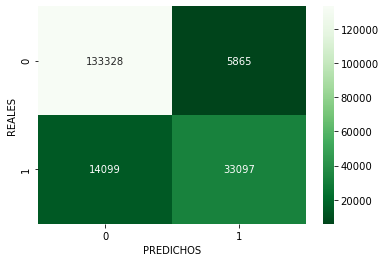

In [32]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat,annot=True,cmap='Greens_r',fmt='g')
plt.xlabel('PREDICHOS')
plt.ylabel('REALES')

<a id="knn"></a>
## KNN
- #### <a href='#top'> Tabla de Contenidos </a>

<img src="./warning.jpg"><br> 
<div style="text-align: center;color:#FF0000"><h2> El proceso de GridSearch puede tardar 7 horas </h2></div>
<div style="text-align: justify">Tener en cuenta que esta configurado para tomar todos los core de la CPU y aún así tarda 7 horas, en caso de querer ejecutar con menos carga de CPU remover el <b>n_jobs=-1</b>.<br><br>Se guardó en un pkl el modelo entrenado que será entregado junto con la notebook.</div>

In [33]:
start_time = timeit.default_timer()
# Instanciamos un modelo KNN
knn_clas = KNeighborsClassifier()

# Especificamos 3 folds para no sobre cargar el Grid Search
folds_knn=StratifiedKFold(n_splits=3, random_state=12, shuffle=True)

# Definimos los hiperparámetros que vamos usar
k_range = (3,5,7)
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

# Hiperparámetros del modelo
param_grid = [param_grid]


# Probamos el modelo con 'accuracy' como scoring lo seteamos para correr en verbose y con todos los nucleos
grid_knn = GridSearchCV(knn_clas, param_grid, cv=folds_knn, scoring='accuracy', verbose= 1, n_jobs=-1)
elapsed = timeit.default_timer() - start_time
elapsed
print(f'El proceso tardó {elapsed/60} minutos')

{'n_neighbors': (3, 5, 7), 'weights': ['uniform', 'distance']}
El proceso tardó 1.008106666660069e-05 minutos


In [34]:
# Tomamos el tiempos de inicio de ejecución
start_time = timeit.default_timer()

# Fiteamos el GridSearch del KNN
grid_results = grid_knn.fit(X_train, y_train)

# Medimos cuanto tardó en ejecutar
elapsed = timeit.default_timer() - start_time
print(f'El proceso tardó {elapsed/60} minutos')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 286.3min finished


El proceso tardó 302.15629992429996 minutos


In [35]:
# Mejor configuración para el KNN
grid_results.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [36]:
# Mejor score al que llega con los mejores parametros
grid_results.best_score_

0.8893508015855643

In [37]:
# Guardo el mejor modelo en un archivo
with open("gridKNN_best.pkl", 'wb') as file:
    pickle.dump(grid_results.best_estimator_, file)

#joblib.dump(grid_results.best_estimator_, 'gridKNN_best.pkl')

In [38]:
# Predigo los valores de y con el X_test ya escalado
y_KNN_pred = grid_results.predict(X_test)

In [39]:
np.save('y_knn_pred_grids.npy', y_KNN_pred)

Text(33.0, 0.5, 'REALES')

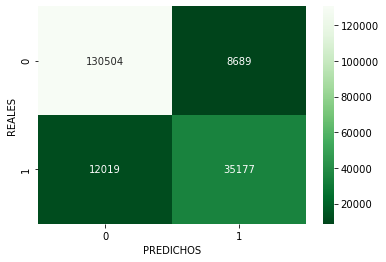

In [40]:
# Armo la matriz de confusión en base a lo predicho en el paso anterior
sns.heatmap(confusion_matrix(y_test, y_KNN_pred), annot=True, cmap='Greens_r',fmt='g')
plt.xlabel('PREDICHOS')
plt.ylabel('REALES')

In [41]:
# Armo el clasification report en base a lo predicho
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_test, y_KNN_pred, target_names = target_names))

               precision    recall  f1-score   support

  AMBULATORIO       0.92      0.94      0.93    139193
HOSPITALIZADO       0.80      0.75      0.77     47196

     accuracy                           0.89    186389
    macro avg       0.86      0.84      0.85    186389
 weighted avg       0.89      0.89      0.89    186389



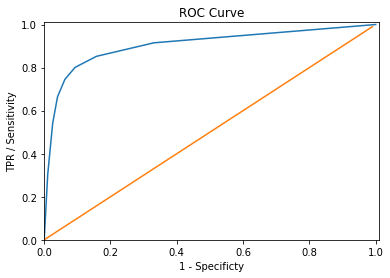

In [42]:
# ROC Curve y AUC
y_pred_proba_knn = grid_results.predict_proba(X_test)

fpr_gnb,tpr_gnb,thr_gnb = roc_curve(y_test, y_pred_proba_knn[:,1])

df = pd.DataFrame(dict(fpr=fpr_gnb, tpr=tpr_gnb, thr = thr_gnb))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [43]:
# Salvo el predict_proba del KNN para el cálculo final
np.save('y_knn_pred_proba_grids.npy', y_pred_proba_knn)

<a id="regresion_logistica"></a>
## Regresión Logistica
- #### <a href='#top'> Tabla de Contenidos </a>



In [44]:
# Recordar que X_train y X_test ya vienen escalados

In [45]:
# Instanciamos el modelo
log_reg = LogisticRegression()

In [46]:
# Ajustamos el modelo
log_reg.fit(X_train, y_train)

LogisticRegression()

In [47]:
# Predecimos sobre test
y_logreg_test_pred = log_reg.predict(X_test)

In [48]:
# Vemos el accuracy score
accuracy_score(y_test, y_logreg_test_pred)

0.8928906748788823

In [49]:
# Cuál es la proporción de hospitalizados y ambulatorios, para ver si el accuracy tiene algún sentido
mexicoInfectadosDummies['TIPO_PACIENTE'].value_counts(normalize = True)

0    0.74679
1    0.25321
Name: TIPO_PACIENTE, dtype: float64

Text(33.0, 0.5, 'Reales')

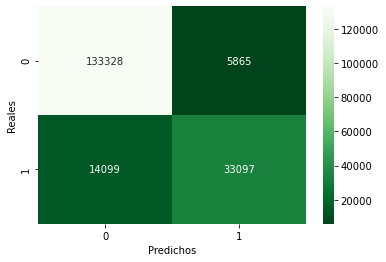

In [50]:
sns.heatmap(confusion_matrix(y_test, y_logreg_test_pred), annot=True, cmap='Greens_r',fmt='g')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [51]:
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_test, y_logreg_test_pred, target_names = target_names))

               precision    recall  f1-score   support

  AMBULATORIO       0.90      0.96      0.93    139193
HOSPITALIZADO       0.85      0.70      0.77     47196

     accuracy                           0.89    186389
    macro avg       0.88      0.83      0.85    186389
 weighted avg       0.89      0.89      0.89    186389



In [52]:
print('Accuracy=', accuracy_score(y_test, y_logreg_test_pred))
print('Recall=', recall_score(y_test, y_logreg_test_pred))
print('Precision=', precision_score(y_test, y_logreg_test_pred))

Accuracy= 0.8928906748788823
Recall= 0.7012670565302144
Precision= 0.8494687131050768


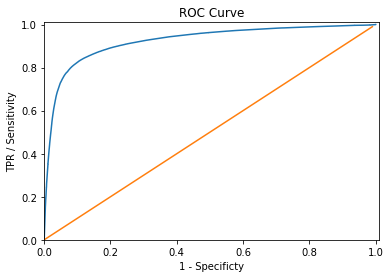

In [53]:
y_pred_proba_log_reg = log_reg.predict_proba(X_test)

fpr_log_reg,tpr_log_reg,thr_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])

df = pd.DataFrame(dict(fpr=fpr_log_reg, tpr=tpr_log_reg, thr = thr_log_reg))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

<a id="regresion_logistica_tune"></a>
### Repetimos tuneando hiperparámetros
- #### <a href='#top'> Tabla de Contenidos </a>

[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) va a necesitar 4 argumentos iniciales: 
- **estimator =**un estimador (es decir, modelo instanciado)
- **param_grid=** una grilla de parametros para recorrer (que tiene que ser un diccionario cuyas claves correspondan a los hiperparámetros del modelo y los valores sean listas de valores que va a recorrer `GridSearchCV`.
- **cv=** la cantidad de folds para la estrategia de validación cruzada
- **scoring=** cuál es la métrica que va a utiliza el método para evaluar cuál es la combinación de hiperparámetros más exitosa. 

Y uno opcional, pero que es muy recomendable ya que estas exploraciones exhaustivas pueden demorar mucho tiempo: 
- **n_jobs=** controla el número de procesadores que corren en paralelo.

In [54]:
# el modelo ya está instanciado y es log_reg

# especificacmos los folds para la validación cruzada
folds=StratifiedKFold(n_splits=10, random_state=12, shuffle=True)

# hiperparámetros del modelo
param_grid = [
    {'C': [1, 10, 100, 1000],
     'penalty': ['l1', 'l2',],
     'solver': ['saga']}
]


# probamos con 'accuracy' como scoring
grid = GridSearchCV(log_reg, param_grid, cv=folds, scoring='accuracy', n_jobs=-1)

In [55]:
start_time = timeit.default_timer()
fit = grid.fit(X_train, y_train)
elapsed = timeit.default_timer() - start_time
elapsed


156.69379681600185

In [56]:
print(grid.best_score_)
print (grid.best_estimator_)
print (grid.best_params_)

0.8920732242215506
LogisticRegression(C=10, penalty='l1', solver='saga')
{'C': 10, 'penalty': 'l1', 'solver': 'saga'}


In [57]:
# Predecimos sobre test
y_test_pred = fit.predict(X_test)

In [58]:
# Vemos el accuracy score
accuracy_score(y_test, y_test_pred)

0.892885309755404

               precision    recall  f1-score   support

  AMBULATORIO       0.90      0.96      0.93    139193
HOSPITALIZADO       0.85      0.70      0.77     47196

     accuracy                           0.89    186389
    macro avg       0.88      0.83      0.85    186389
 weighted avg       0.89      0.89      0.89    186389

Accuracy= 0.892885309755404
Recall= 0.7012670565302144
Precision= 0.8494469111721377


Text(33.0, 0.5, 'Reales')

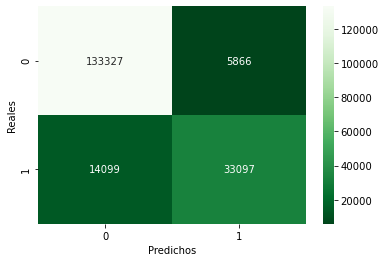

In [59]:
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_test, y_test_pred, target_names = target_names))

print('Accuracy=', accuracy_score(y_test, y_test_pred))
print('Recall=', recall_score(y_test, y_test_pred))
print('Precision=', precision_score(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='Greens_r',fmt='g')
plt.xlabel('Predichos')
plt.ylabel('Reales')


### Veamos qué diferencia habría usando los parámetros por default de la Regresión Logística


               precision    recall  f1-score   support

  AMBULATORIO       0.90      0.96      0.93    139193
HOSPITALIZADO       0.85      0.70      0.77     47196

     accuracy                           0.89    186389
    macro avg       0.88      0.83      0.85    186389
 weighted avg       0.89      0.89      0.89    186389

Accuracy= 0.8928906748788823
Recall= 0.7012670565302144
Precision= 0.8494687131050768


Text(33.0, 0.5, 'Reales')

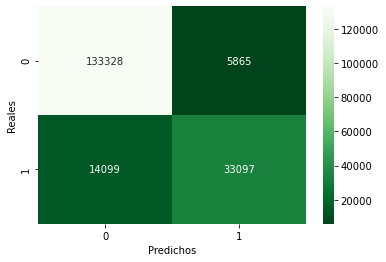

In [60]:
## Prueba con log reg con parámetros stad
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_test_pred1 = lr.predict(X_test)
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_test, y_test_pred1, target_names = target_names))

print('Accuracy=', accuracy_score(y_test, y_test_pred1))
print('Recall=', recall_score(y_test, y_test_pred1))
print('Precision=', precision_score(y_test, y_test_pred1))
sns.heatmap(confusion_matrix(y_test, y_test_pred1), annot=True, cmap='Greens_r',fmt='g')
plt.xlabel('Predichos')
plt.ylabel('Reales')



#### Vemos que los resultados con los parámetros elegidos por el gridsearch y los de default, dan prácticamente los mismos resultados

(NOTA: si corremos el gridsearch utilizando como parámetro de scoring el "recall", da los mismos valores que con el modelo con los parámetros por default")

### En nuestro problema, lo que más nos interesa es identificar bien a los positivos, es decir tener un buen valor de recall o sensibilidad

<a id="grafico_precission_recall"></a>
 
### Gráfico precission-recall de scikit-learn
- #### <a href='#top'> Tabla de Contenidos </a>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [61]:

y_score = fit.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.83


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.83')

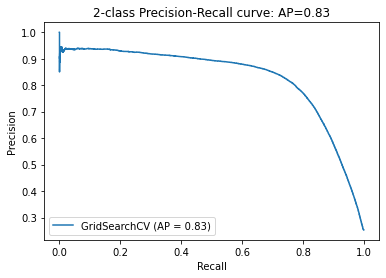

In [62]:

disp = plot_precision_recall_curve(fit, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

<a id="naive_gauss"></a>
## Naive Gauss
- #### <a href='#top'> Tabla de Contenidos </a>

In [63]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [64]:
y_pred = gnb.predict(X_test)

round(accuracy_score(y_test, y_pred), 3)

0.724

In [65]:
# confusion matrix

conf_mat = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', conf_mat)

print('\nTrue Positives(TP) = ', conf_mat[1,1])

print('\nTrue Negatives(TN) = ', conf_mat[0,0])

print('\nFalse Positives(FP) = ', conf_mat[0,1])

print('\nFalse Negatives(FN) = ', conf_mat[1,0])


Confusion matrix

 [[91447 47746]
 [ 3690 43506]]

True Positives(TP) =  43506

True Negatives(TN) =  91447

False Positives(FP) =  47746

False Negatives(FN) =  3690


Text(33.0, 0.5, 'Reales')

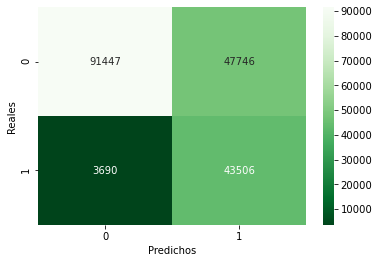

In [66]:
conf_mat_df = pd.DataFrame(data=conf_mat, 
                           index=['0', '1'], 
                           columns=['0', '1'])

sns.heatmap(conf_mat_df, annot=True, cmap='Greens_r',fmt='g');
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [67]:
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_test, y_pred, target_names = target_names))

               precision    recall  f1-score   support

  AMBULATORIO       0.96      0.66      0.78    139193
HOSPITALIZADO       0.48      0.92      0.63     47196

     accuracy                           0.72    186389
    macro avg       0.72      0.79      0.70    186389
 weighted avg       0.84      0.72      0.74    186389



In [68]:
gnb.predict_proba(X_test)[:,1]

array([0.45509355, 0.12727636, 0.99976044, ..., 0.92464962, 0.9999998 ,
       0.05523746])

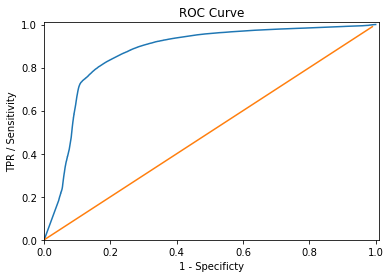

In [69]:
# ROC Curve y AUC
y_pred_proba = gnb.predict_proba(X_test)

from sklearn.metrics import roc_curve
fpr_gnb,tpr_gnb,thr_gnb = roc_curve(y_test, y_pred_proba[:,1])

df = pd.DataFrame(dict(fpr=fpr_gnb, tpr=tpr_gnb, thr = thr_gnb))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

<a id="comp_model"></a>
## Comparacion de Modelos
- #### <a href='#top'> Tabla de Contenidos </a>


<img src="./warning_cinta_slim.png">

<div style="text-align: center;color:#FF0000"><h1> Carga de Modelo KNN </h1></div>
<div style="text-align: justify">Este proceso carga desde el disco el modelo KNN que resulta del Grid Search y el resultado del predict_proba para los pasos que siguen. No se debería ejecutar si ya se ejecutó el proceso de Grid Search.</div>

In [ ]:
#Carga el modelo KNN que resolvio el Grid Search
loaded_model = pickle.load(open('gridKNN_best.pkl', 'rb'))


In [ ]:
#Carga el modelo KNN que resolvio el Grid Search
y_pred_proba_knn = np.load('y_knn_pred_proba_grids.npy')


<img src="./warning_cinta_slim.png">

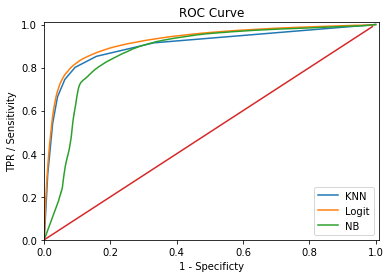

In [70]:
# Curva ROC de los tres modelos
fpr_knn_clas,tpr_knn_clas,thr_knn_clas = roc_curve(y_test, y_pred_proba_knn[:,1])
fpr_log_reg,tpr_log_reg,thr_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_gnb,tpr_gnb,thr_gnb = roc_curve(y_test, y_pred_proba[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_knn_clas,tpr_knn_clas)
plt.plot(fpr_log_reg,tpr_log_reg)
plt.plot(fpr_gnb,tpr_gnb)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(["KNN",'Logit','NB'])
plt.show() 

In [71]:
from sklearn.metrics import auc
print('AUC-KNN=', auc(fpr_knn_clas,tpr_knn_clas))
print('AUC-Logit=', auc(fpr_log_reg,tpr_log_reg))
print('AUC-NB=', auc(fpr_gnb,tpr_gnb))

AUC-KNN= 0.9032139852817783
AUC-Logit= 0.9232704922847842
AUC-NB= 0.8697957888097771


Cada una de las distintas herramientas y métricas nos van a permitir comparar distintos modelos que entrenemos y tomar decisiones respecto de cuál es el óptimo para usar (siempre teniendo en cuenta el contexto del problema y la lógica de negocio que tenga detrás).

<a id="conclusiones"></a>
 
### Conclusiones
- #### <a href='#top'> Tabla de Contenidos </a>

Nuestra logica de problema es poder estimar los recursos necesarios para hacer frente a los pacientes que van a ser hospitalizados. Por ello es importante que nuestro modelo sea capaz de predecir tratando de minimizar los casos falsos negativos (FN), ya que esto implicaria una subestimacion de casos hospitalizados y por ende no poder hacer frente a la posible  demanda de camas.

Segun lo observado de la comparacion de las Curvas ROC y AUC el modelo que mejor performa es el de **Regresion Logistica** dado que maximiza el AUC.

<a id="teoria"></a>
 
### Un poco de teoria
- #### <a href='#top'> Tabla de Contenidos </a>

Dado que Naive Bayes es tan fácil de optimizar y tan rápido desde el punto de vista computacional, es un buen "baseline" para un problema de clasificación.

Si performa bien, podemos quedarnos con este modelo y si necesitamos mejorar la precisión, tenemos una línea de base sobre la cual mejorar.

**Naive Bayes tiende a funcionar bien en las siguientes situaciones:**

- Cuando se cumplen los supuestos (cosa que rara vez pasa en casos reales)
- Cuando las clases están muy bien separadas y no es necesaria tanta complejidad en el modelo.
- Cuando tenemos datos con muy alta dimensionalidad (por ejemplo text mining) donde la complejidad del modelo también es menos importante porque hay mucha información para cada observación.

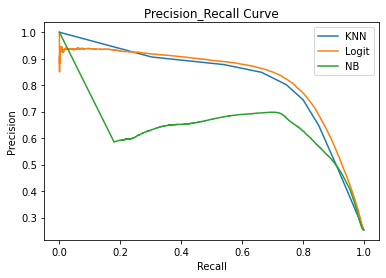

In [72]:
# Curva Precision_Recall de los tres modelos
Pre_knn_clas,Rec_knn_clas,PRthr_knn_clas = precision_recall_curve(y_test, y_pred_proba_knn[:,1])
Pre_log_reg,Rec_log_reg,PRthr_log_reg = precision_recall_curve(y_test, y_pred_proba_log_reg[:,1])
Pre_gnb,Rec_gnb,PRthr_gnb = precision_recall_curve(y_test, y_pred_proba[:,1])

plt.axis('auto')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_Recall Curve')
plt.plot(Rec_knn_clas,Pre_knn_clas)
plt.plot(Rec_log_reg, Pre_log_reg)
plt.plot(Rec_gnb,Pre_gnb)
plt.legend(["KNN",'Logit','NB'])
plt.show()

In [73]:
# Area bajo la curva Precision_Recall
print('AUC-KNN=', auc(Rec_knn_clas,Pre_knn_clas))
print('AUC-Logit=', auc(Rec_log_reg, Pre_log_reg))
print('AUC-NB=', auc(Rec_gnb,Pre_gnb))

AUC-KNN= 0.81993843262754
AUC-Logit= 0.8295213870278568
AUC-NB= 0.6472572049291205


<a id="reglog_analisis"></a>
 
### Analizando la Regresion Logistica
- #### <a href='#top'> Tabla de Contenidos </a>

#### Miremos el umbral con los datos de Train

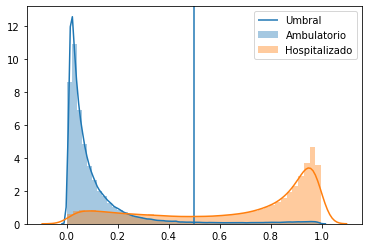

In [74]:
# Histograma de probabilidades

sns.distplot(log_reg.predict_proba(X_train[y_train==0])[:,1])
sns.distplot(log_reg.predict_proba(X_train[y_train==1])[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Ambulatorio', 'Hospitalizado'])

In [75]:
umbral = 0.2
probs = log_reg.predict_proba(X_train)[:,1]
y_pred_train = probs > umbral

Text(33.0, 0.5, 'Reales')

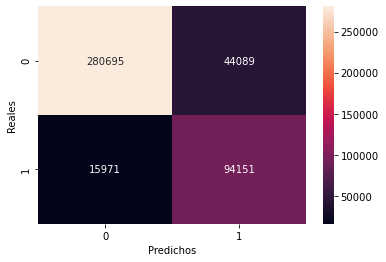

In [76]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [77]:
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_train, y_pred_train, target_names = target_names))

               precision    recall  f1-score   support

  AMBULATORIO       0.95      0.86      0.90    324784
HOSPITALIZADO       0.68      0.85      0.76    110122

     accuracy                           0.86    434906
    macro avg       0.81      0.86      0.83    434906
 weighted avg       0.88      0.86      0.87    434906



#### Miremos el umbral con los datos de Test

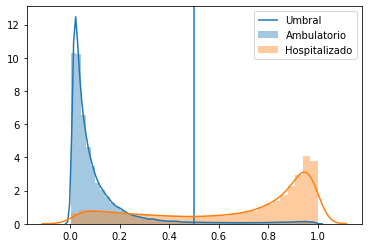

In [78]:
# Histograma de probabilidades

sns.distplot(log_reg.predict_proba(X_test[y_test==0])[:,1])
sns.distplot(log_reg.predict_proba(X_test[y_test==1])[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Ambulatorio', 'Hospitalizado'])

In [79]:
umbral = 0.2
probs = log_reg.predict_proba(X_test)[:,1]
y_pred_test = probs > umbral

Text(33.0, 0.5, 'Reales')

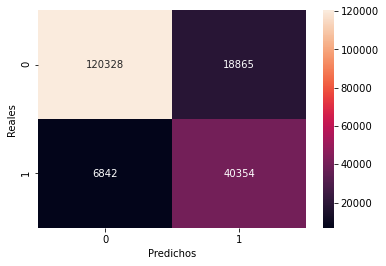

In [80]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [81]:
target_names = ['AMBULATORIO', 'HOSPITALIZADO']
print(classification_report(y_test, y_pred_test, target_names = target_names))

               precision    recall  f1-score   support

  AMBULATORIO       0.95      0.86      0.90    139193
HOSPITALIZADO       0.68      0.86      0.76     47196

     accuracy                           0.86    186389
    macro avg       0.81      0.86      0.83    186389
 weighted avg       0.88      0.86      0.87    186389



#### Importante: 
Modificando el umbral de decisión, baja la exactitud del modelo, pero ahora detecta correctamente 40354 (86% aprox.) de los casos positivos.